In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/polynomial-regression/Ice_cream selling data.csv


Dataset Overview:

   Temperature (°C)  Ice Cream Sales (units)
0         -4.662263                41.842986
1         -4.316559                34.661120
2         -4.213985                39.383001
3         -3.949661                37.539845
4         -3.578554                32.284531

Dataset Shape: (49, 2)

Missing Values:
 Temperature (°C)           0
Ice Cream Sales (units)    0
dtype: int64


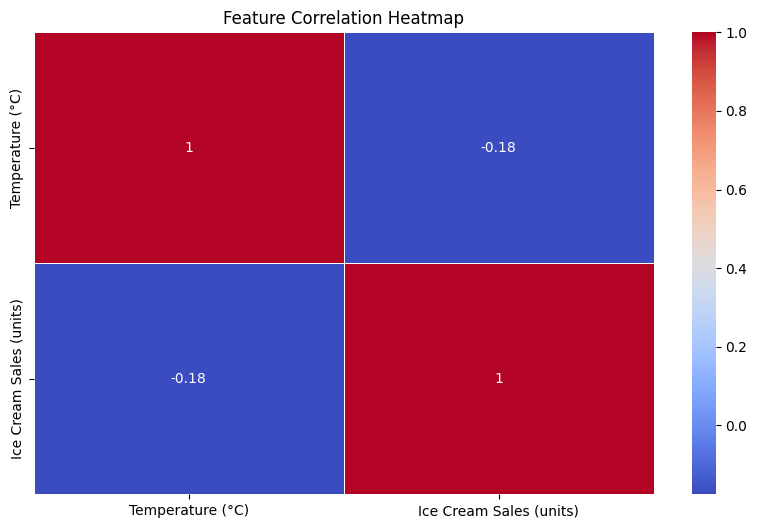

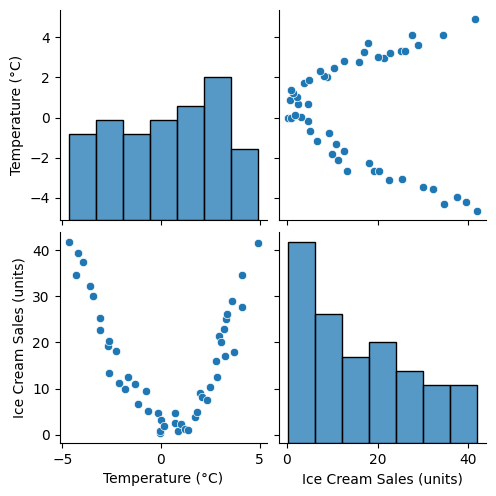

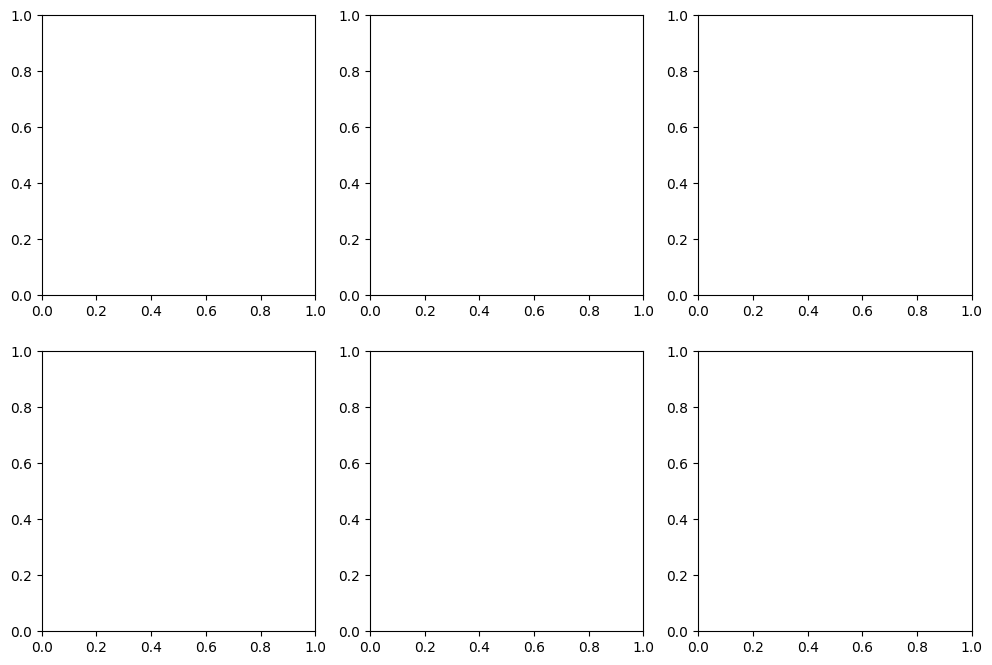

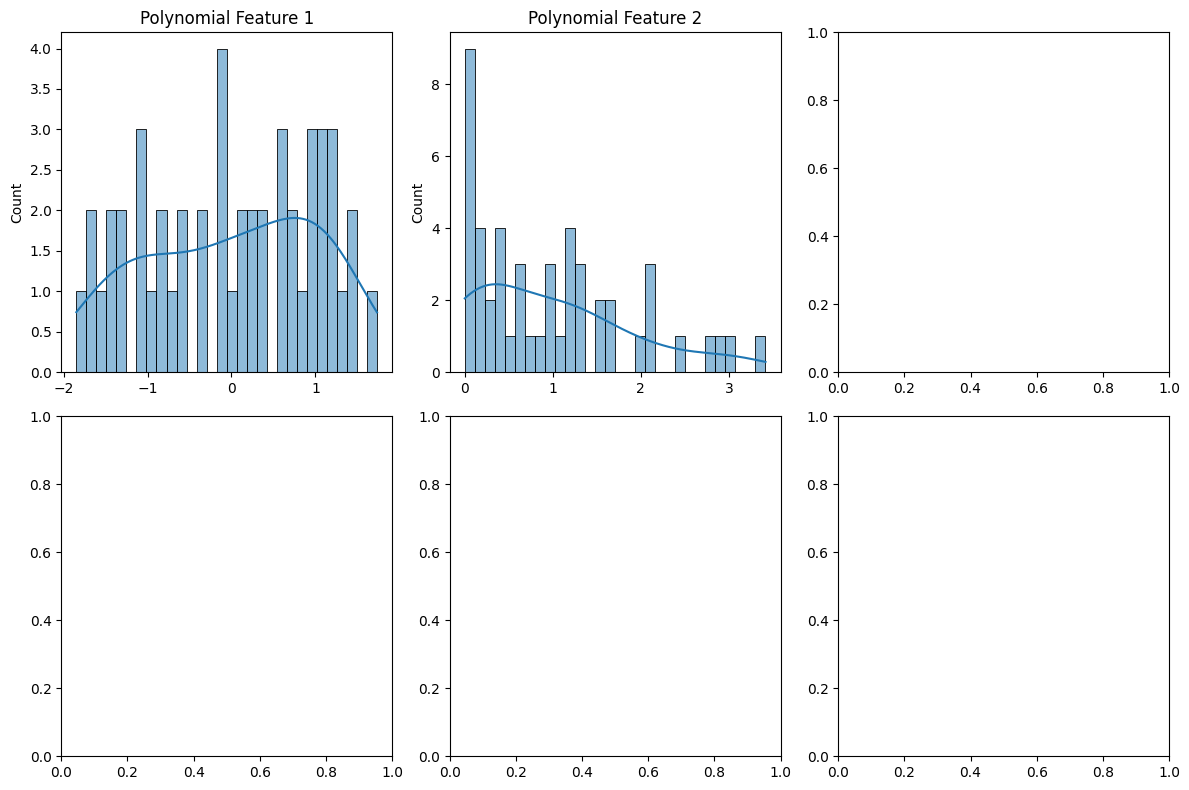

<Figure size 640x480 with 0 Axes>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load dataset
df = pd.read_csv("/kaggle/input/polynomial-regression/Ice_cream selling data.csv")  # Replace with actual dataset

# Display dataset info
print("Dataset Overview:\n")
print(df.head())  # Show first few rows
print("\nDataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

# Independent and dependent variables
X = df.iloc[:, :-1].values  # All independent variables
y = df.iloc[:, -1].values  # Dependent variable

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Save processed data
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

# ----------- Visualization -----------
# 1. Heatmap for Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# 2. Pairplot of the dataset
sns.pairplot(df)
plt.show()

# 3. Polynomial Features Distribution
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
num_features = X_poly.shape[1]  # Get actual number of features
num_plots = min(6, num_features)  # Limit to 6 plots or available features

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_plots):  # Adjust iteration to available features
    sns.histplot(X_poly[:, i], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Polynomial Feature {i+1}')

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import statsmodels.api as sm

def backward_elimination(X, y, significance_level=0.05):
    num_vars = X.shape[1]
    
    while num_vars > 0:
        X_with_const = sm.add_constant(X)  # Add intercept term
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues[1:]  # Exclude the intercept
        
        max_p_value = np.max(p_values)
        if max_p_value > significance_level:
            worst_feature = np.argmax(p_values)  # Find index of highest p-value
            X = np.delete(X, worst_feature, axis=1)  # Remove that feature
            num_vars -= 1
        else:
            break  # Stop if all p-values are below significance level

    return X

# Apply backward elimination
X_train_be = backward_elimination(X_train, y_train)
X_test_be = X_test[:, :X_train_be.shape[1]]  # Keep same number of columns in test set


In [16]:
import numpy as np
import statsmodels.api as sm
from itertools import combinations

# Load data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Add intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Forward selection function
def forward_selection(X, y, significance_level=0.05):
    selected_features = []
    num_features = X.shape[1]
    
    for i in range(num_features):
        best_feature = None
        best_p_value = float("inf")

        for feature in range(num_features):
            if feature in selected_features:
                continue
            temp_features = selected_features + [feature]
            model = sm.OLS(y, X[:, temp_features]).fit()
            p_value = model.pvalues.max()

            if p_value < best_p_value:
                best_feature = feature
                best_p_value = p_value

        if best_p_value < significance_level:
            selected_features.append(best_feature)
        else:
            break

    return X[:, selected_features]

X_train_fs = forward_selection(X_train, y_train)
X_test_fs = X_test[:, :X_train_fs.shape[1]]

# Fit model
model = sm.OLS(y_train, X_train_fs).fit()
y_pred = model.predict(X_test_fs)

# Performance metrics
r2 = model.rsquared
adj_r2 = model.rsquared_adj

print(f"Forward Selection - R²: {r2}, Adjusted R²: {adj_r2}")


Forward Selection - R²: 0.9370575812696705, Adjusted R²: 0.9353564348174994


In [17]:
import numpy as np
import statsmodels.api as sm

# Load data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Add intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Stepwise Selection (Bidirectional)
def bidirectional_selection(X, y, significance_level=0.05):
    selected_features = list(range(X.shape[1]))

    while True:
        model = sm.OLS(y, X[:, selected_features]).fit()
        p_values = model.pvalues[1:]  # Exclude constant term

        # Backward Step: Remove highest p-value
        if p_values.max() > significance_level:
            selected_features.pop(p_values.argmax())
        else:
            break

        # Forward Step: Add best new feature
        remaining_features = list(set(range(X.shape[1])) - set(selected_features))
        for feature in remaining_features:
            temp_features = selected_features + [feature]
            model = sm.OLS(y, X[:, temp_features]).fit()
            if model.pvalues[-1] < significance_level:
                selected_features.append(feature)
    
    return X[:, selected_features]

X_train_bs = bidirectional_selection(X_train, y_train)
X_test_bs = X_test[:, :X_train_bs.shape[1]]

# Fit model
model = sm.OLS(y_train, X_train_bs).fit()
y_pred = model.predict(X_test_bs)

# Performance metrics
r2 = model.rsquared
adj_r2 = model.rsquared_adj

print(f"Bidirectional Selection - R²: {r2}, Adjusted R²: {adj_r2}")


Bidirectional Selection - R²: 0.9413665676490518, Adjusted R²: 0.9381091547406658


In [18]:
import numpy as np
import statsmodels.api as sm

# Load data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Add intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit model with all variables
model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

# Performance metrics
r2 = model.rsquared
adj_r2 = model.rsquared_adj

print(f"All Variables - R²: {r2}, Adjusted R²: {adj_r2}")


All Variables - R²: 0.9413665676490518, Adjusted R²: 0.9381091547406658
